In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning':0})

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning':0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [3]:
os.getcwd()

'/Users/duorouli'

In [4]:
start = datetime.now()
if os.path.isfile('data.csv'):
    os.remove('data.csv') 
    data = open('data.csv',mode = 'w')
    
    row = list()
    files = ['/Users/duorouli/Downloads/archive (1)/combined_data_1.txt','/Users/duorouli/Downloads/archive (1)/combined_data_2.txt',
            '/Users/duorouli/Downloads/archive (1)/combined_data_3.txt']
    for file in files:
        print('Reading ratings from {}...'.format(file))
        with open(file) as f:
            for line in f:
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':','')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0,movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken:',datetime.now()-start)

Reading ratings from /Users/duorouli/Downloads/archive (1)/combined_data_1.txt...
Done.

Reading ratings from /Users/duorouli/Downloads/archive (1)/combined_data_2.txt...
Done.

Reading ratings from /Users/duorouli/Downloads/archive (1)/combined_data_3.txt...
Done.

Time taken: 0:01:25.160569


In [5]:
print("creating the dataframe from data.csv file...")
df = pd.read_csv('data.csv',sep = ',',names = ['movie','user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')
df.sort_values(by = 'date',inplace = True)

creating the dataframe from data.csv file...
Done.



In [6]:
df.head()

,movie,user,rating,date
53877162,9798,510180,3,1999-11-11
45316022,8079,510180,2,1999-11-11
56431994,10341,510180,4,1999-11-11
68725149,12473,510180,5,1999-11-11
48101611,8651,510180,2,1999-11-11


In [7]:
df.describe()['rating']

count    7.363298e+07
mean     3.597498e+00
std      1.087146e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [8]:
## checking for the NAN values
# just to make sure that all Nan containing rows are deleted..
sum(df.isnull().any())

0

In [9]:
# Removing Duplicates
dup_bool= df.duplicated(['movie','user','rating'])
dups = sum(dup_bool)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [10]:
print("\nTotal no of rating :",df.shape[0])
print('Total No of users :',len(np.unique(df.user)))
print('Total No of movies :',len(np.unique(df.movie)))


Total no of rating : 73632984
Total No of users : 479453
Total No of movies : 13367


In [78]:
os.getcwd()
if os.path.isfile('train.csv'):
    os.remove('train.csv')
if os.path.isfile('test.csv'):
    os.remove('test.csv')

In [77]:
df.iloc[:int(df.shape[0]*0.01)]

,movie,user,rating,date
53877162,9798,510180,3,1999-11-11
45316022,8079,510180,2,1999-11-11
56431994,10341,510180,4,1999-11-11
68725149,12473,510180,5,1999-11-11
48101611,8651,510180,2,1999-11-11
...,...,...,...,...
58838892,10809,1687642,3,2001-01-20
40219066,7145,486399,4,2001-01-20
299870,77,256358,4,2001-01-20
3123210,571,256358,5,2001-01-20


In [79]:
## Splitting data into Train and Test

if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.01)].to_csv('train.csv',index = False)
if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.01):int(df.shape[0]*0.012)].to_csv('test.csv',index = False)
    
train_df = pd.read_csv('train.csv',parse_dates=['date'])
test_df = pd.read_csv('test.csv')

In [80]:
# method to make y_axis more readable
def human(num,units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + 'K'
    elif units == 'm':
        return str(num/10**6) + 'M'
    elif units == 'b':
        return str(num/10**9) + 'B'
    


/var/folders/ll/jvzd_hvs51j8yv5s0wr73xn40000gn/T/ipykernel_51255/103111921.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>


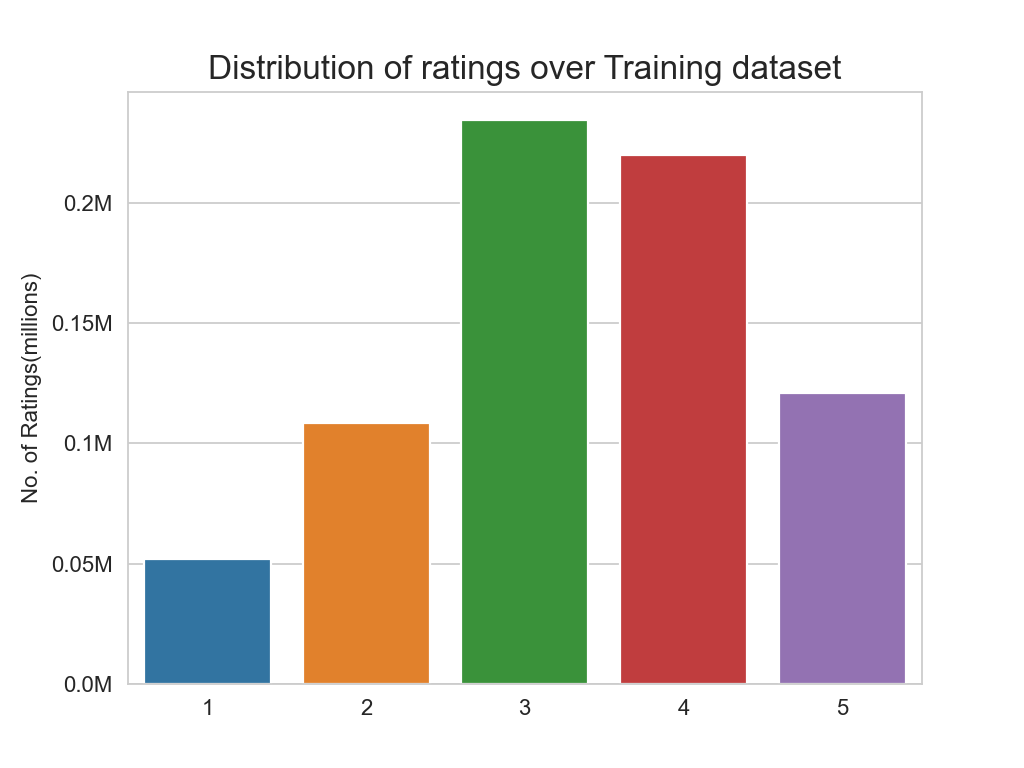

In [81]:
fig,ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset',fontsize = 15)
data = train_df['rating'].value_counts()
sns.barplot(x=data.index,y=data.values)
ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(millions)')
plt.show()

In [82]:
#pd.optioons.mode.chained_assignment = None
train_df['day_of_week'] = train_df.date.dt.day_name()
train_df.tail()

,movie,user,rating,date,day_of_week
736324,10809,1687642,3,2001-01-20,Saturday
736325,7145,486399,4,2001-01-20,Saturday
736326,77,256358,4,2001-01-20,Saturday
736327,571,256358,5,2001-01-20,Saturday
736328,8016,1366739,4,2001-01-20,Saturday


/var/folders/ll/jvzd_hvs51j8yv5s0wr73xn40000gn/T/ipykernel_51255/3997775327.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>


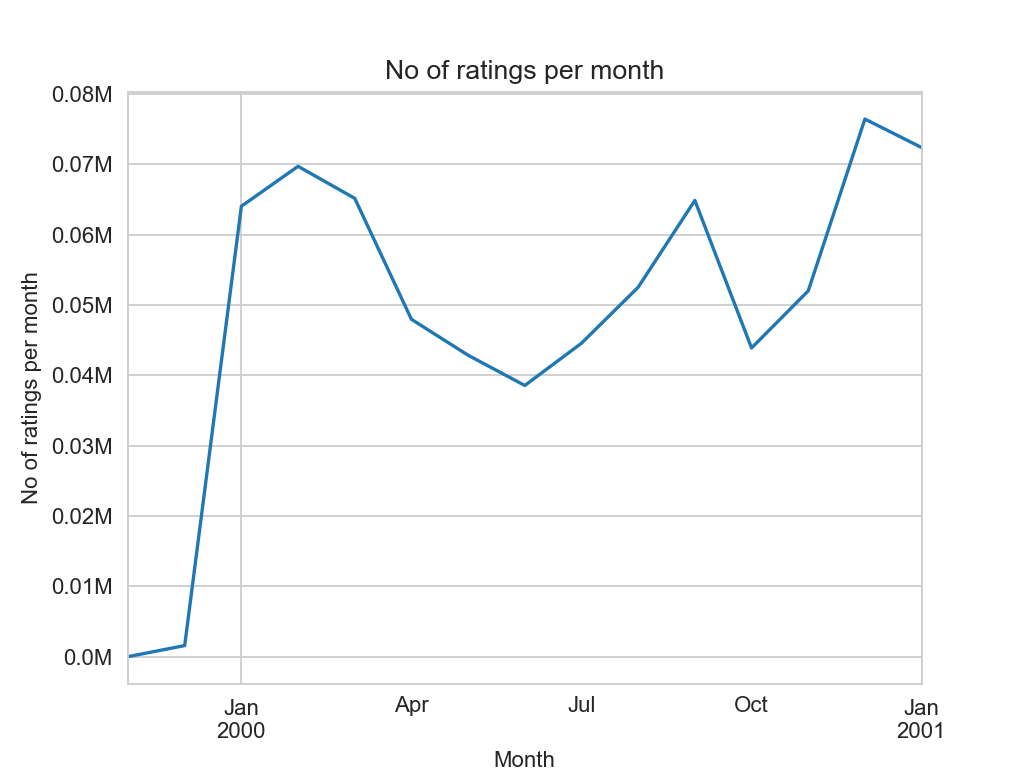

In [83]:
## number of ratings per month
ax = train_df.resample('m',on = 'date')['rating'].count().plot()
ax.set_title('No of ratings per month')
plt.xlabel('Month')
plt.ylabel('No of ratings per month')
ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])
plt.show()

In [84]:
no_of_rated_movies_per_user = train_df.groupby(by = 'user')['rating'].count().sort_values(ascending = False)
no_of_rated_movies_per_user.head()

user
2372141    1301
1902838    1205
306569     1170
1838390    1153
2012897    1109
Name: rating, dtype: int64

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

<IPython.core.display.Javascript object>


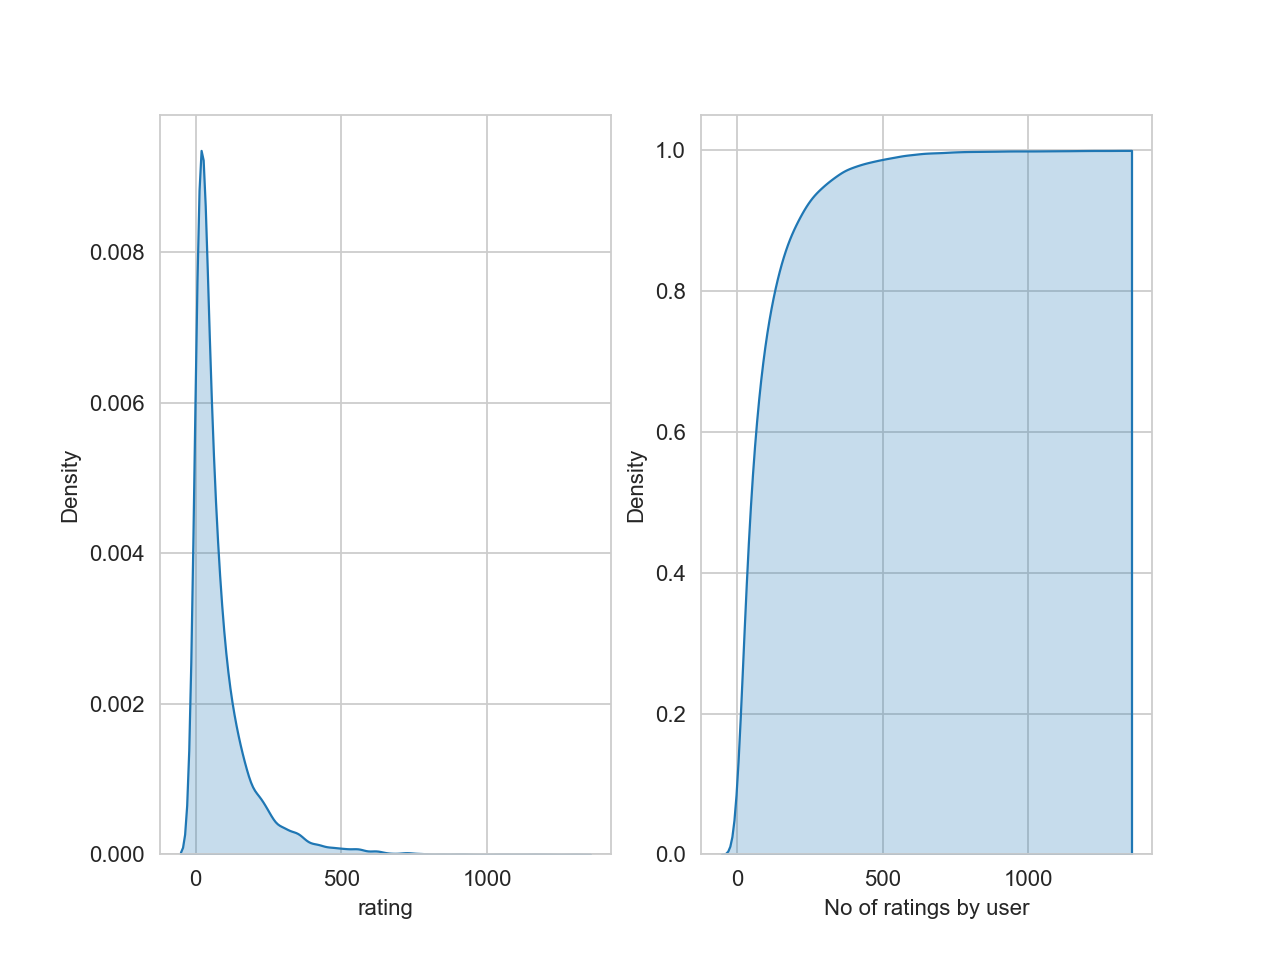

In [86]:
sns.kdeplot(no_of_rated_movies_per_user,fill=True,ax = axs[0])
plt.xlabel('No of ratings by user')

sns.kdeplot(no_of_rated_movies_per_user,fill=True,ax = axs[1],cumulative = True)
plt.xlabel('No of ratings by user')
plt.show()
## Most users gave very few ratings from the above plots

In [87]:
os.remove('train_sparse_matrix.npz')

In [88]:
##create sparse matrix from data frame
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print('It is present in your pwd, getting it from disk...')
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print('Done..')
else:
    print('We are creating sparse_matrix from the dateframe..')
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values,(train_df.user.values,train_df.movie.values)),)
    print('Done. It\'s shape is : (user,movie):',train_sparse_matrix.shape)
    print('Saving it into disk for further usage..')
    
    sparse.save_npz('train_sparse_matrix.npz',train_sparse_matrix)
    print('Done..\n')
print(datetime.now()-start)

We are creating sparse_matrix from the dateframe..
Done. It's shape is : (user,movie): (2649297, 13367)
Saving it into disk for further usage..
Done..

0:00:00.457241


In [89]:
train_sparse_matrix.shape

(2649297, 13367)

In [90]:
## sparsity of train sparse Matrix
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print('sparsity of train matrix: {}%'.format((1-(elem/(us*mv)))*100))

sparsity of train matrix: 99.99792074713025%


In [91]:
os.remove('test_sparse_matrix.npz')

In [92]:
## create sparse matrix from test data frame
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print('It is present in your pwd, getting it from disk...')
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print('Done..')
else:
    print('We are creating sparse_matrix from the dataframe..')
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values,(test_df.user.values,test_df.movie.values)))
    print('Done. It\'s shape is:(user,movie):',test_sparse_matrix.shape)
    print('Saving it into disk for further usage..')
    sparse.save_npz('test_sparse_matrix.npz',test_sparse_matrix)
    print('Done..\n')
print(datetime.now()-start)

We are creating sparse_matrix from the dataframe..
Done. It's shape is:(user,movie): (2649297, 13367)
Saving it into disk for further usage..
Done..

0:00:00.156339


In [93]:
## sparsity of test data matrix
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
1-elem/(us*mv)

0.9999958414886129

In [94]:
## cold start problem: there are lots of user and movies do not appear in train dataset
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

netflix_svd = TruncatedSVD(n_components = 100,algorithm = 'randomized',random_state = 15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)
print(datetime.now()-start)

0:01:46.737786


<IPython.core.display.Javascript object>


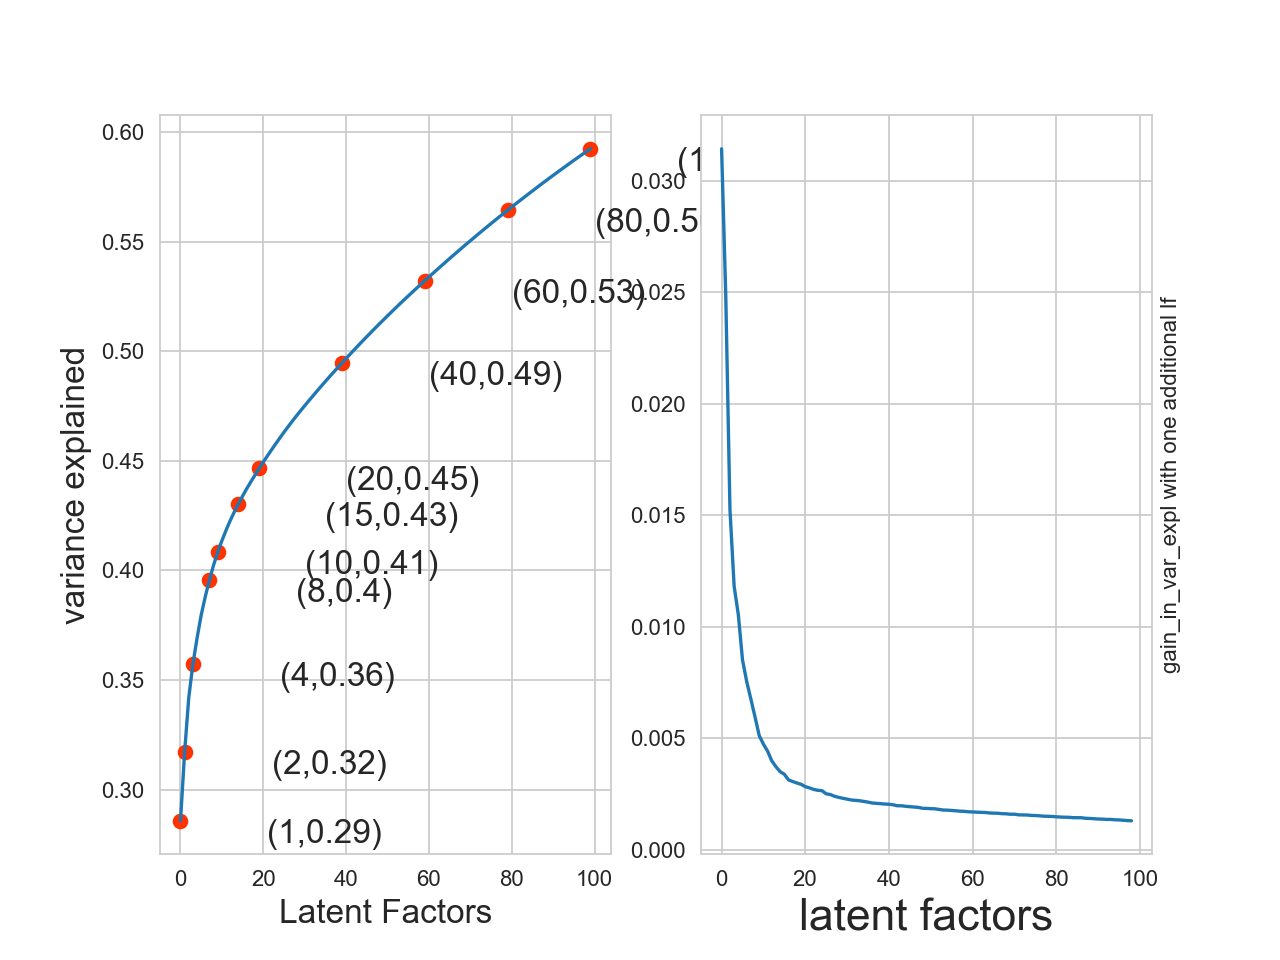

In [118]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)
fig,ax = plt.subplots(1, 2, figsize = (8,6))
ax1,ax2 = ax[0],ax[1]
ax1.set_ylabel('variance explained',fontsize = 15)
ax1.set_xlabel('Latent Factors',fontsize = 15)
ax1.plot(expl_var)

ind = [1,2,4,8,10,15,20,40,60,80,100]
ax1.scatter(x = [i-1 for i in ind],y = expl_var[[i-1 for i in ind]],c = '#ff3300')
for i in ind:
     ax1.annotate(text = '({},{})'.format(i,np.round(expl_var[i-1],2)),
                  xy = (i-1,expl_var[i-1]),
                  xytext = (i+20,expl_var[i-1]-0.01),fontsize = 15)
change_in_expl_var = [expl_var[i+1]-expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)

ax2.set_ylabel('gain_in_var_expl with one additional lf',fontsize = 10)
ax2.yaxis.set_label_position('right')
ax2.set_xlabel('latent factors',fontsize = 20)

plt.show()

In [130]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    trunc_sparse_matrix = sparse.csr_matrix(trunc_svd)
    sparse.save_npz('trunc_sparse_matrix',trunc_sparse_matrix)
else:
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

In [131]:
trunc_sparse_matrix.shape

(2649297, 100)

In [132]:
## compute movie_movie similarity matrix
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output = False)
    print('Done...')
    print('Saving it to disk without the need of re-computing it again..')
    sparse.save_npz('m_m_sim_sparse.npz',m_m_sim_sparse)
else:
    print('It is there, we will get it.')
    m_m_sim_sparse = sparse.load_npz('m_m_sim_sparse.npz')
    print('Done')
print(m_m_sim_sparse.shape)
print(datetime.now()-start)

It seems you don't have that file. Computing movie_movie similarity
Done...
Saving it to disk without the need of re-computing it again..
(13367, 13367)
0:00:04.418142


In [133]:
## only take those top similiar movie ratings and store them in a seprate dictionary
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [143]:
start = datetime.now()
similiar_movies = dict()
for movie in movie_ids:
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similiar_movies[movie] = sim_movies[:100]
print(datetime.now()-start)
similiar_movies[15]

array([13215, 13113, 12622, ...,    77,    57,    46], dtype=int32)

In [186]:
movies = []
with open('/Users/duorouli/Downloads/movie_titles.csv',encoding = 'ISO-8859-1') as f:
    for line in f.readlines():
        content = line.split(',')[:3]
        movies.append(content)
movie_titles = pd.DataFrame(movies,columns = ['movie_id','release_year','title']).set_index('movie_id')

In [188]:
movie_titles

,release_year,title
movie_id,,
1,2003,Dinosaur Planet\n
2,2004,Isle of Man TT 2004 Review\n
3,1997,Character\n
4,1994,Paula Abdul's Get Up & Dance\n
5,2004,The Rise and Fall of ECW\n
...,...,...
17766,2002,Where the Wild Things Are and Other Maurice Se...
17767,2004,Fidel Castro: American Experience\n
17768,2000,Epoch\n


In [193]:
## similiar movies for 'vampire journals'
mv_id = 67
print('\nMovie ------>',movie_titles.iloc[mv_id,:].values[1])
print('\nIt has {} ratings from users.'.format(train_sparse_matrix[:,mv_id].getnnz()))
print('\nWe have {} movies which are similiar this and we will get only top most '.format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie ------> Invader Zim


It has 9 ratings from users.

We have 1837 movies which are similiar this and we will get only top most 


In [195]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()
similiar_indices = similarities.argsort()[::-1][1:]
similarities[similiar_indices]
sim_indices = similarities.argsort()[::-1][1:]

<IPython.core.display.Javascript object>


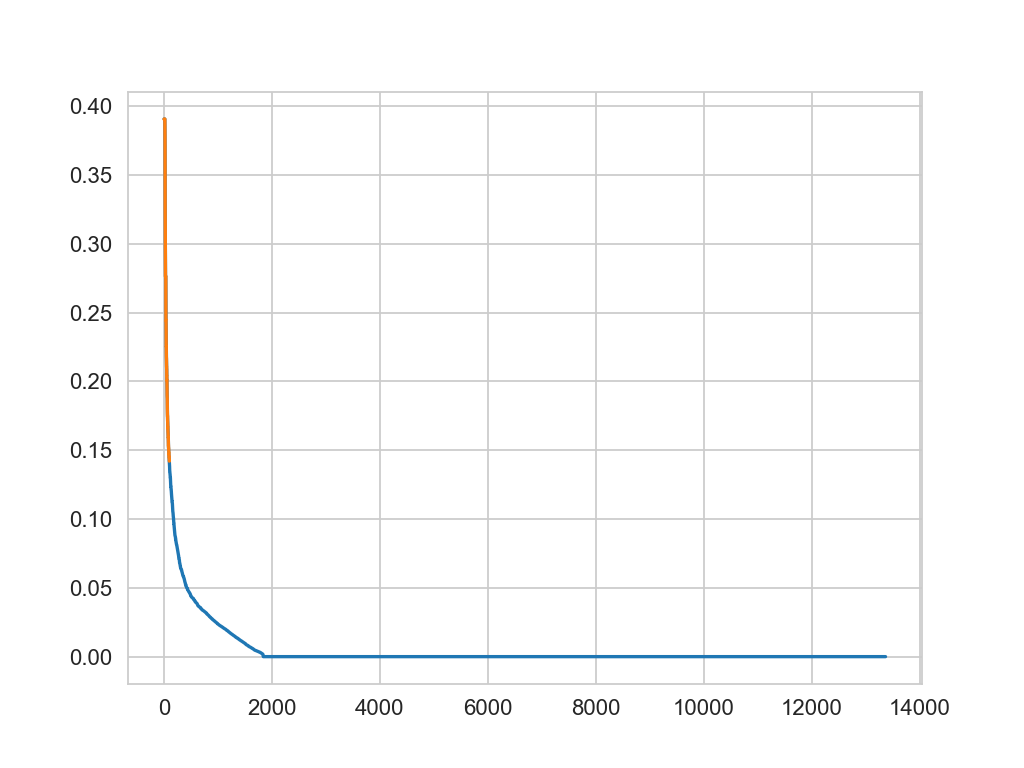

In [196]:
plt.plot(similarities[sim_indices],label = 'All the ratings')
plt.plot(similarities[sim_indices[:100]],label = 'top 100 similar movies')
plt.show()

In [197]:
## Machine Learning Models

In [244]:
def get_sample_sparse_matrix(sparse_matrix,no_users,no_movies,path, verbose = True):
    row_ind,col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)
    
    print('original matrix{},,{}'.format(len(users),len(movies)))
    print('original matrix{}'.format(len(ratings)))
    
    np.random.seed(15)
    sample_users = np.random.choice(users,no_users,replace = False)
    sample_movies = np.random.choice(movies,no_movies,replace = False)
    
    mask = np.logical_and(np.isin(row_ind,sample_users),np.isin(col_ind,sample_movies))
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask],
                                              (row_ind[mask],col_ind[mask])),
                                                 shape = (max(sample_users)+1,max(sample_movies)+1))
    sample_sparse_matrix
    if verbose:
        print('sample matrix:{}{}'.format(len(sample_users),len(sample_movies)))
        print('sample matrix:rating'.format(ratings[mask].shape[0]))
    print('saving it into disk for further usage..')
    sparse.save_npz(path,sample_sparse_matrix)
    if verbose:
        print('Done')
    return sample_sparse_matrix

In [248]:
os.remove('sample_train_sparse_matrix.npz')

In [249]:
## sampling data
path = 'sample_train_sparse_matrix.npz'
if os.path.isfile(path):
    sample_train_sparse_matrix = sparse.load_npz(path)
else:
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix,
                                                         no_users = 3000,
                                                         no_movies = 300,
                                                         path = path)
print(datetime.now()-start)

original matrix8876,,3507
original matrix736329
sample matrix:3000300
sample matrix:rating
saving it into disk for further usage..
Done
1:58:22.909724


In [250]:
## build sample test data from the test data
path = 'sample_test_sparse_matrix.npz'
if os.path.isfile(path):
    sample_train_sparse_matrix = sparse.load_npz(path)
else:
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix,
                                                         no_users = 1000,
                                                         no_movies = 100,
                                                         path = path)
print(datetime.now()-start)

original matrix8876,,3507
original matrix736329
sample matrix:1000100
sample matrix:rating
saving it into disk for further usage..
Done
1:58:26.611724


In [251]:
## featuring train data
sample_train_users, sample_train_movies,sample_train_ratings=sparse.find(sample_train_sparse_matrix)